# Natural Language Processing with Disaster Tweets

Kaggle Data: [source](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv)

Columns

-   id - a unique identifier for each tweet
-   text - the text of the tweet
-   location - the location the tweet was sent from (may be blank)
-   keyword - a particular keyword from the tweet (may be blank)
-   target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


In [1]:
# ! pip install wordcloud
# ! pip install nltk
# ! pip install spacy

In [2]:
# General
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import pandas as pd

# Visualization
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Text
import re
import nltk
import spacy
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk_stopwords = stopwords.words('english')
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = list(nlp.Defaults.stop_words.copy())

In [3]:
# import training data
df = pd.read_csv("./data/nlp-disaster_train.csv")

In [4]:
# the length of the dataframe
len(df)

7613

In [5]:
# investigate the data
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# check for null values
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
# fill null keyword and location with none
df['keyword'].fillna('none', inplace=True)
df['location'].fillna('none', inplace=True)

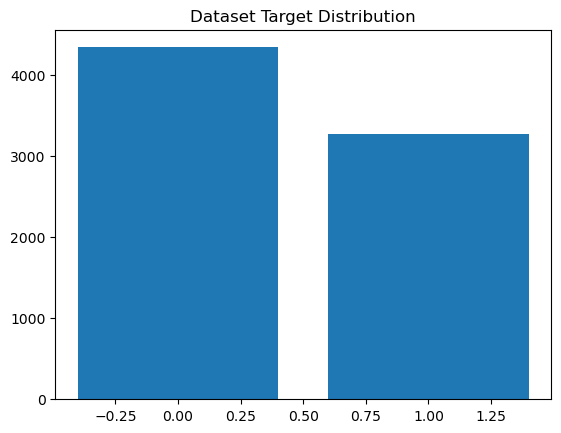

In [8]:
# visualize the number of negative and positive examples by creating a counter of the target column and displaying a bar chart
target_count = Counter(df.target)
plt.bar(target_count.keys(), target_count.values())
plt.title("Dataset Target Distribution")
plt.show()

This bar chart is showing us that there are 3271 tweets labelled as about a real disaster and 4342 tweets labelled as not.


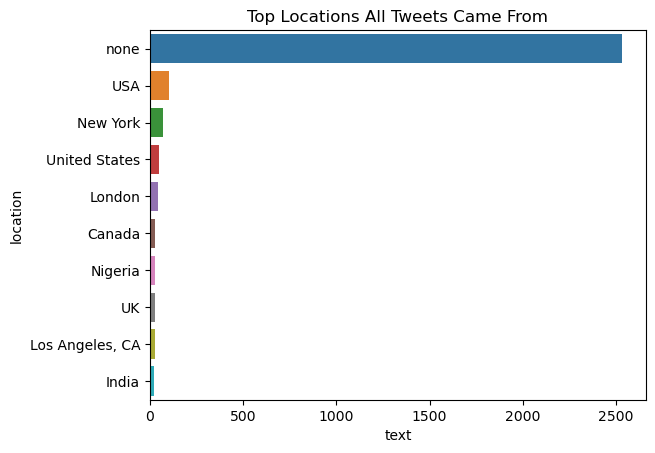

In [9]:
# Where are the top 10 locations in the dataset?
top_10 = df.groupby(['location']).count(
).text.sort_values(ascending=False)[:10]
sns.barplot(x=top_10, y=top_10.index)
plt.title("Top Locations All Tweets Came From")
plt.show()

This bar chart is showing us that the most popular location to tweet from is "none" indicating that most users do not have their location services turned on.


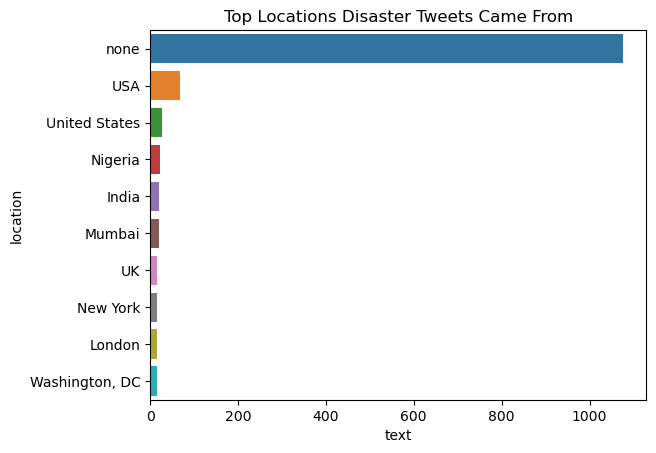

In [10]:
# Where are the top 30 locations in the dataset?
top_10_disaster = df[df['target'] == 1].groupby(
    ['location']).count().text.sort_values(ascending=False)[:10]
sns.barplot(x=top_10_disaster, y=top_10_disaster.index)
plt.title("Top Locations Disaster Tweets Came From")
plt.show()

In [11]:
# clean the text data
def process(text: str) -> str:
    """
    Preprocesses textual data from tweets to retain only words.

    Args:
        text (str): The input text to be processed.

    Returns:
        str: The processed text with hyperlinks, hashtags, mentions, numbers,
             punctuation, and single letters (excluding 'I' and 'a') removed.
    """

    text = text.lower()

    # remove hyperlinks
    hyperlink_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(hyperlink_pattern, '', text)

    # remove hashtags and mentions
    hashtag_pattern = r'(@\w+|#\w+)'
    text = re.sub(hashtag_pattern, '', text)

    # remove numbers
    text = re.sub(r'\d', '', text)

    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # removes single letters except I and a
    single_letter_pattern = r'(?<![ia])\b\w\b(?!=[ia])'
    text = re.sub(single_letter_pattern, '', text)

    return text

In [12]:
# create a new column to hold the processed text
df.loc[:, 'processed_text'] = df.loc[:, 'text'].apply(lambda x: process(x))

In [13]:
# combine two sets of stopwords into a new set with no duplicates
all_stopwords = set(nltk_stopwords + spacy_stopwords)

In [14]:
def remove_stop_words(text: str) -> str:
    """
    Removes stop words from the input text.

    Args:
        text (str): The input text from which stop words will be removed.

    Returns:
        str: The input text with stop words removed.
    """
    filtered = [word for word in text.split() if word not in all_stopwords]
    text = ' '.join(filtered)
    return text

In [15]:
df.loc[:, 'processed_text'] = df.loc[:, 'processed_text'].apply(
    lambda x: remove_stop_words(x))

In [16]:
df

,id,keyword,location,text,target,processed_text
0,1,none,none,Our Deeds are the Reason of this #earthquake M...,1,deeds reason allah forgive
1,4,none,none,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,none,none,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,none,none,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation orders california
4,7,none,none,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school
...,...,...,...,...,...,...
7608,10869,none,none,Two giant cranes holding a bridge collapse int...,1,giant cranes holding bridge collapse nearby homes
7609,10870,none,none,@aria_ahrary @TheTawniest The out of control w...,1,control wild fires california northern state t...
7610,10871,none,none,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utckm volcano hawaii
7611,10872,none,none,Police investigating after an e-bike collided ...,1,police investigating ebike collided car little...


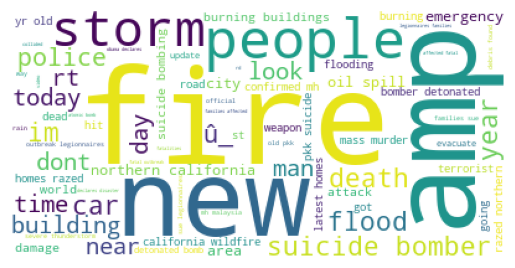

In [17]:
# Build a word cloud for disaster tweets
text = " ".join(df[df['target'] == 1]['processed_text'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

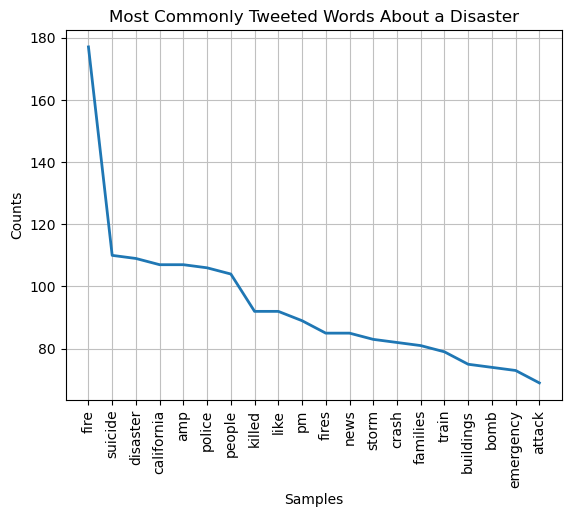

In [18]:
# What are the most frequent words for disaster tweets?
tokens = []
for text in df[df['target'] == 1]['processed_text']:
    tokens.extend(word_tokenize(text))

most_common_words = FreqDist(tokens)

most_common_words.plot(20, cumulative=False,
                       title="Most Commonly Tweeted Words About a Disaster")
plt.show()

This shows us that the most common words tweeted in a disaster are "fire", "suicide" and "disaster".
